<a href="https://colab.research.google.com/github/ClaudeCoulombe/VIARENA/blob/master/Labos/Lab-CIFAR_10/Identification_Objets-ResConv-CIFAR_10.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Rappel - Fonctionnement d'un carnet web iPython

* Pour exécuter le code contenu dans une cellule d'un carnet iPython, cliquez dans la cellule et faites (⇧↵, shift-enter) 
* Le code d'un carnet iPython s'exécute séquentiellement de haut en bas de la page. Souvent, l'importation d'une bibliothèque Python ou l'initialisation d'une variable est préalable à l'exécution d'une cellule située plus bas. Il est donc recommandé d'exécuter les cellules en séquence. Enfin, méfiez-vous des retours en arrière qui peuvent réinitialiser certaines variables.

# Identification d'objets à partir de photos - jeu de données CIFAR-10
## Labo réseau convolutif - architecture de base

Inspiration: TensorFlow Tutorial <a href="https://www.tensorflow.org/tutorials/images/cnn?hl=fr" target='_blank'>Tutoriel TensorFlow - Réseau neuronal convolutif</a>



## Jeu de données - photos CIFAR-10
L'ensemble de données CIFAR-10 (Canadian Institute For Advanced Research) comporte 60 000 photographies en couleur de 32×32 pixels d'objets de 10 classes différentes. Il est relativement simple d'atteindre une précision de 80 %. On peut obtenir des performances de 90 % avec ces données avec des réseaux neuronaux convolutifs. 

* 0 : avion
* 1 : automobile
* 2 : oiseau
* 3 : chat
* 4 : cerf
* 5 : chien
* 6 : grenouille
* 7 : cheval
* 8 : bateau
* 9 : camion


TensorFlow version: 2.4.1
Keras version: 2.4.3

Entraînement: attributs=(50000, 32, 32, 3), classes-cibles=(50000, 1)
Test: attributs=(10000, 32, 32, 3), classes-cibles=(10000, 1)

Quelques images avec leur étiquette de classe-cible...


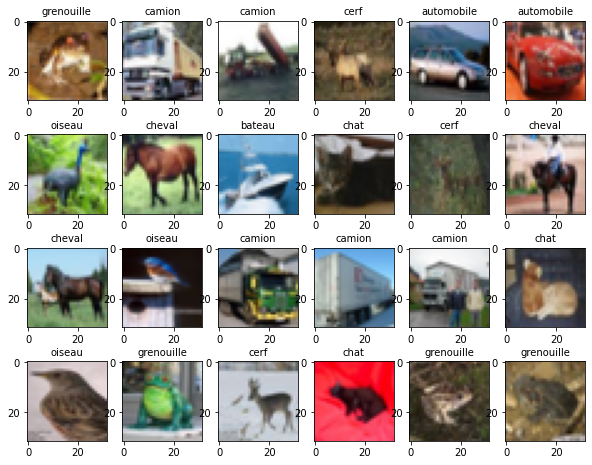

In [79]:
import os
import matplotlib.pyplot as plt

import tensorflow as tf
print("TensorFlow version:",tf.__version__)
import keras
print("Keras version:",keras.__version__)

# Importer le jeu de données CIFAR-10
from keras.datasets import cifar10

dic_noms_classe = { 
    0 : "avion",
    1 : "automobile",
    2 : "oiseau",
    3 : "chat",
    4 : "cerf",
    5 : "chien",
    6 : "grenouille",
    7 : "cheval",
    8 : "bateau",
    9 : "camion",
}

# Lire le jeu de données CIFAR-10 et le diviser entre
# les données d'entrainement et les données de test
(attributs_entrainement, classes_cibles_entrainement), (attributs_test, classes_cibles_test) = cifar10.load_data()

# résumé des données 
print()
print('Entraînement: attributs=%s, classes-cibles=%s' % (attributs_entrainement.shape, classes_cibles_entrainement.shape))
print('Test: attributs=%s, classes-cibles=%s' % (attributs_test.shape, classes_cibles_test.shape))

# Afficher les 24 premières images
print()
print("Quelques images avec leur étiquette de classe-cible...")
%matplotlib inline
# définir lagrill d'affichage des images
fig, axes = plt.subplots(nrows=4,ncols=6,figsize=(10,8))
for i_rangee in range(0,4):
    for i_colonne in range(0,6):
        axes[i_rangee,i_colonne].set_title(dic_noms_classe[int(classes_cibles_entrainement[i_rangee*6+i_colonne])],
                                           fontsize=10)
        axes[i_rangee,i_colonne].imshow(attributs_entrainement[i_rangee*6+i_colonne])
plt.show()

In [80]:
# Conversion des classes-cibles en vecteurs binaires à un bit discriminant
from keras.utils import to_categorical

classes_cibles_entrainement = to_categorical(classes_cibles_entrainement)
classes_cibles_test = to_categorical(classes_cibles_test)

# Normalisation

def normalisation(entrainement, test):
    # convertir de nombres entiers à nombres décimaux
    entrainement_normalise = entrainement.astype('float32')
    test_normalise = test.astype('float32')
    # normalisation à un nombre entre 0 et 1
    entrainement_normalise = entrainement_normalise / 255.0
    test_normalise = test_normalise / 255.0
    return entrainement_normalise, test_normalise

attributs_entrainement, attributs_test = normalisation(attributs_entrainement, attributs_test)

print("Normalisation terminée!")

Normalisation terminée!


## Modèle de base

In [99]:
## Construction du modèle

from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense

print("Création d'un modèle de base...")

input_shape = (32, 32, 3)
batch_size = 32
# ou nombre de classes
nombre_classes_cibles = 10

modele_de_base = Sequential()

# Apprentissage et extraction des attributs
modele_de_base.add(Conv2D(32, 
                          kernel_size=(3,3),
                          activation='relu',
                          kernel_initializer='glorot_uniform',
                          padding='same',
                          strides=(1,1),
                          input_shape=input_shape))
modele_de_base.add(MaxPooling2D(pool_size=(2,2)))

# Classification des images
# Classificateur perceptron multicouche
modele_de_base.add(Flatten())
modele_de_base.add(Dense(128,
                         activation='relu'))
modele_de_base.add(Dense(nombre_classes_cibles, 
                         activation='softmax'))

print()
print("Description du modèle de base:")
modele_de_base.summary()

Création d'un modèle de base...

Description du modèle de base:
Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_52 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_21 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dense_37 (Dense)             (None, 128)               1048704   
_________________________________________________________________
dense_38 (Dense)             (None, 10)                1290      
Total params: 1,050,890
Trainable params: 1,050,890
Non-trainable params: 0
_________________________________________________________________


In [100]:
# Compilation du modèle

print()
print("Compilation du modèle de base...")

modele_de_base.compile(loss="categorical_crossentropy", 
                       optimizer="adam", 
                       metrics=["accuracy"])


Compilation du modèle de base...


In [101]:
# Entraînement du modèle

print()
print("Entraînement du modèle de base...")

batch_size = 128
epochs = 15

traces_entrainement = modele_de_base.fit(attributs_entrainement,
                                         classes_cibles_entrainement,
                                         batch_size=batch_size,
                                         epochs=epochs,
                                         validation_split=0.1)


Entraînement du modèle de base...
Epoch 1/15
352/352 [==============================] - 26s 71ms/step - loss: 1.8935 - accuracy: 0.3270 - val_loss: 1.3781 - val_accuracy: 0.5270
Epoch 2/15
352/352 [==============================] - 22s 62ms/step - loss: 1.3177 - accuracy: 0.5357 - val_loss: 1.2475 - val_accuracy: 0.5678
Epoch 3/15
352/352 [==============================] - 22s 62ms/step - loss: 1.1691 - accuracy: 0.5922 - val_loss: 1.1630 - val_accuracy: 0.5986
Epoch 4/15
352/352 [==============================] - 23s 64ms/step - loss: 1.0691 - accuracy: 0.6264 - val_loss: 1.0953 - val_accuracy: 0.6236
Epoch 5/15
352/352 [==============================] - 23s 66ms/step - loss: 1.0148 - accuracy: 0.6492 - val_loss: 1.1065 - val_accuracy: 0.6114
Epoch 6/15
352/352 [==============================] - 26s 74ms/step - loss: 0.9643 - accuracy: 0.6635 - val_loss: 1.0657 - val_accuracy: 0.6316
Epoch 7/15
352/352 [==============================] - 26s 74ms/step - loss: 0.9089 - accuracy: 0.6843

In [102]:
# Évaluation du modèle
print()
print("Évaluation du modèle de base...")

resultats = modele_de_base.evaluate(attributs_test, etiquettes_cibles_test, verbose=0)
print("Exactitude test: {:.2f}%".format(resultats[1]*100))


Évaluation du modèle de base...
Exactitude test: 65.33%


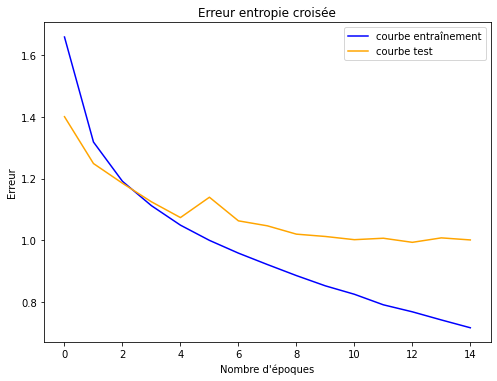

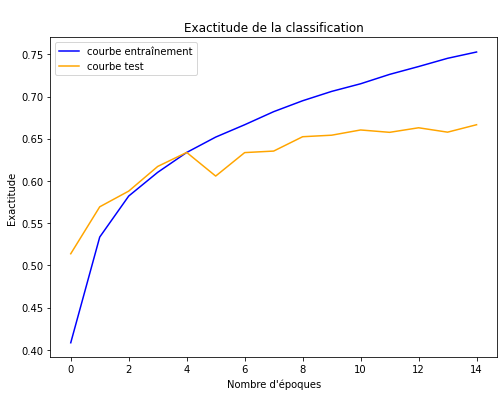

In [89]:
# Affichage des courbes d'entraînement
hauteur = 8
plt.subplots(figsize=(hauteur,1.618*hauteur))
plt.subplot(211)
plt.title('Erreur entropie croisée')
plt.plot(traces_entrainement.history['loss'], color='blue', label='courbe entraînement')
plt.plot(traces_entrainement.history['val_loss'], color='orange', label='courbe test')
plt.ylabel("Erreur")
plt.xlabel("Nombre d'époques")
plt.legend()
plt.show()
# tracer l'exactitude
plt.subplots(figsize=(hauteur,1.618*hauteur))
plt.subplot(212)
plt.title('\nExactitude de la classification')
plt.plot(traces_entrainement.history['accuracy'], color='blue', label='courbe entraînement')
plt.plot(traces_entrainement.history['val_accuracy'], color='orange', label='courbe test')
plt.ylabel("Exactitude")
plt.xlabel("Nombre d'époques")
plt.legend()
plt.show()
# Sauvegarde du graphique en format .png
# nom_graphique = "modele_de_base-courbes_entraînement.png"
# plt.savefig(nom_graphique)
# plt.close()

In [105]:
print("Carnet IPython exécution terminée!")


Carnet IPython exécution terminée!
